# MODEL 

Cargamos las librerias necesarias

In [1]:
from _utils import *
import pandas as pd

## Cargamos la data

In [2]:
dataset = pd.read_json("./datasets/market_data.json", orient="records")

## Preparamos la data

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
def get_series_by_coin(coin: str, df: pd.DataFrame):
    new_df = df.where(df["name"] == coin).dropna()
    return new_df

In [5]:
df_bitcoin = get_series_by_coin("Bitcoin",dataset)
df_bitcoin.set_index("datetime", inplace=True)
df_bitcoin = df_bitcoin.sort_index()
df_bitcoin.head(5)

,id,serialId,symbol,name,slug,open,high,low,close,volume
datetime,,,,,,,,,,
2012-12-02,1e31218a-e44e-4285-820c-8282ee222035,6057.0,BTC,Bitcoin,bitcoin,12.665000,12.679990,12.261722,12.500020,196673.627491
2012-12-03,1e31218a-e44e-4285-820c-8282ee222035,6057.0,BTC,Bitcoin,bitcoin,12.490810,12.678990,12.320000,12.678990,398306.113232
2012-12-04,1e31218a-e44e-4285-820c-8282ee222035,6057.0,BTC,Bitcoin,bitcoin,12.678990,13.499263,12.433030,13.409927,883930.986576
2012-12-05,1e31218a-e44e-4285-820c-8282ee222035,6057.0,BTC,Bitcoin,bitcoin,13.400557,13.420000,12.700000,13.375447,436643.789962
2012-12-06,1e31218a-e44e-4285-820c-8282ee222035,6057.0,BTC,Bitcoin,bitcoin,13.300010,13.688800,12.908408,13.232808,677529.566308


# Estacionalidad

In [6]:
# Va del 1 de enero de 2009 al 24 de septiembre de 2014
# Es decir casi 6 años
print(df_bitcoin.index[0])
print(df_bitcoin.index[-1])
print(df_bitcoin.index[-1]-df_bitcoin.index[0])

2012-12-02 00:00:00
2024-06-09 00:00:00
4207 days 00:00:00


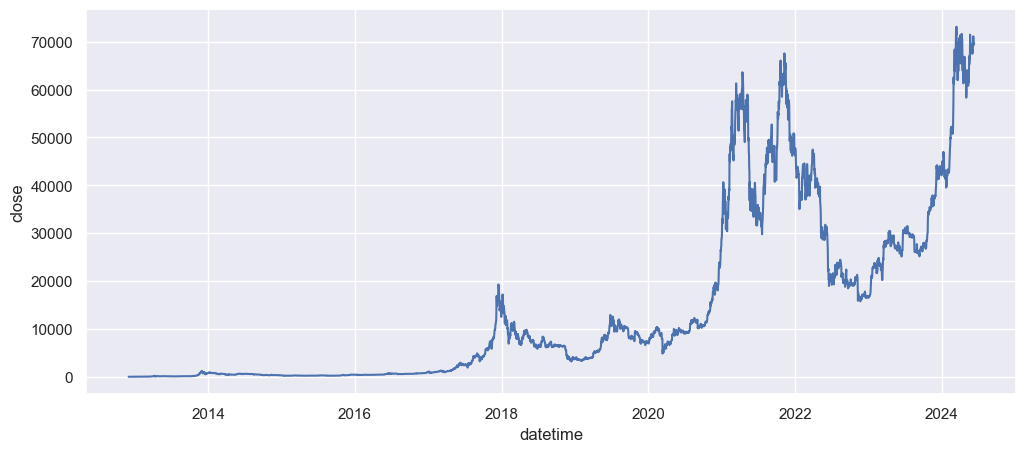

In [7]:
# Importar seaborn
import plotly.express as px
import numpy as np
import seaborn as sns
sns.set()

# Extraer la temperatura
temp = df_bitcoin['close']

# Y graficarla
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(temp, ax=ax);

In [8]:
# 0. Parámetros de la serie de tiempo
N = len(temp)      # Cantidad de muestras: [muestras]
muestras_hora = 1            # Número de muestras/horas: [muestras/h]

# 1. Calcular la magnitud de la Transformada de Fourier derecha
tf = np.abs(np.fft.rfft(temp,N))

# 2. Calcular vector frecuencias (eje horizontal)
frecs = np.fft.rfftfreq(N, d=1./muestras_hora)

# 3. Graficar
# Como tenemos 1 muestra por hora pero la serie dura varios años
# usaremos una escala logarítmica en el eje horizontal
fig = px.line(x=frecs, y=tf, log_x=True)
fig.update_layout(xaxis_title=f'Frecuencia (1/H)')
fig.show()

# Preparacion

In [9]:
#Variables for training
cols = list(df_bitcoin)[-1:4:-1]
print(cols) 

['volume', 'close', 'low', 'high', 'open']


Preparamos los datos para series de tiempo

In [10]:
# Función para generar las particiones preservando las características
# de la serie de tiempo
def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación

    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
tr, vl, ts = train_val_test_split(df_bitcoin[cols])

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (3375, 5)
Tamaño set de validación: (421, 5)
Tamaño set de prueba: (423, 5)


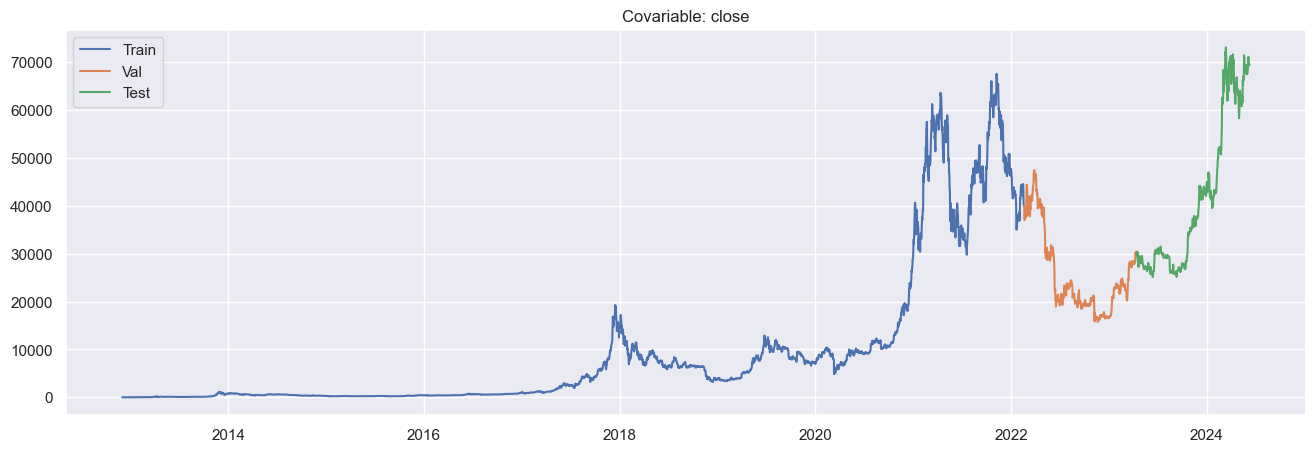

In [11]:
covar = 8 # Índice de la covariable (columna del dataset) a graficar
col = df_bitcoin.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.legend();

In [12]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado <-- <--- ¡esta parte de la función se ejecuta en este caso!
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [13]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 24   # Hiperparámetro
OUTPUT_LENGTH = 4    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (3347, 24, 5), y_tr: (3347, 4, 1)
Set de validación - x_vl: (393, 24, 5), y_vl: (393, 4, 1)
Set de prueba - x_ts: (395, 24, 5), y_ts: (395, 4, 1)


In [14]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir

    
    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df_bitcoin[cols].columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NSAMPLES = data_input['x_tr'].shape[1]
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [15]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'close' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

## Modelamos

In [ ]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf


# El modelo
N_UNITS = 128  # Tamaño del estado oculto (h) y de la celdad de memoria (c) (128)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])  # 24 (horas) x 13 (features)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))

# Y lo único que cambia con respecto al modelo multivariado + multi-step es
# el tamaño deldato de salida (4 horas)
modelo.add(
    Dense(OUTPUT_LENGTH, activation="linear")
)  # activation = 'linear' pues queremos pronosticar (regresión)


# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred - y_true)))
    return rmse


# Compilación
optimizador = RMSprop(learning_rate=5e-4)  # 5e-5
modelo.compile(
    optimizer=optimizador,
    loss=root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 80  # Hiperparámetro
BATCH_SIZE = 256  # Hiperparámetro
historia = modelo.fit(
    x=x_tr_s,
    y=y_tr_s,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_vl_s, y_vl_s),
    verbose=2,
)

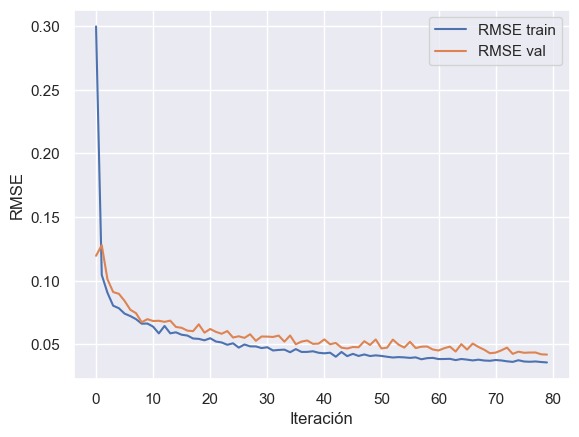

In [17]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

In [18]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.024
  RMSE val:	 0.039
  RMSE test:	 0.049


In [30]:
# Predicciones
def predecir(modelo, x, scaler):
    '''Realiza predicciones con el modelo entrenado.

    Parámetros:
    - modelo: modelo entrenado
    - x: dataset de entrada (escalado)
    - scaler: escalador usado para la variable a predecir

    Retorna:
    - pred: predicciones
    - real: valores reales
    '''

    # Realizar predicciones
    pred = modelo.predict(x)

    # Invertir el escalado
    pred_inv = scaler.inverse_transform(pred)
    return pred_inv

In [70]:
ts

,volume,close,low,high,open
datetime,,,,,
2023-04-15,4.455009e+09,30308.929819,30234.314838,30599.148716,30486.692977
2023-04-16,4.936184e+09,30318.024411,30155.100220,30558.783004,30308.579990
2023-04-17,7.885492e+09,29448.557051,29285.167837,30325.058495,30315.948804
2023-04-18,8.529005e+09,30390.603564,29163.690058,30468.159218,29447.139803
2023-04-19,1.133238e+10,28814.454042,28668.347617,30409.086433,30392.005233
...,...,...,...,...,...
2024-06-05,1.960925e+10,71106.456344,70391.398455,71740.526715,70546.222290
2024-06-06,1.498466e+10,70772.259202,70183.051691,71608.150190,71097.537698
2024-06-07,2.227691e+10,69335.019537,68582.338757,71923.585995,70772.034966


In [89]:
x_tr_s.shape

(3347, 24, 5)

In [106]:
pred_ts.shape

(395, 4)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


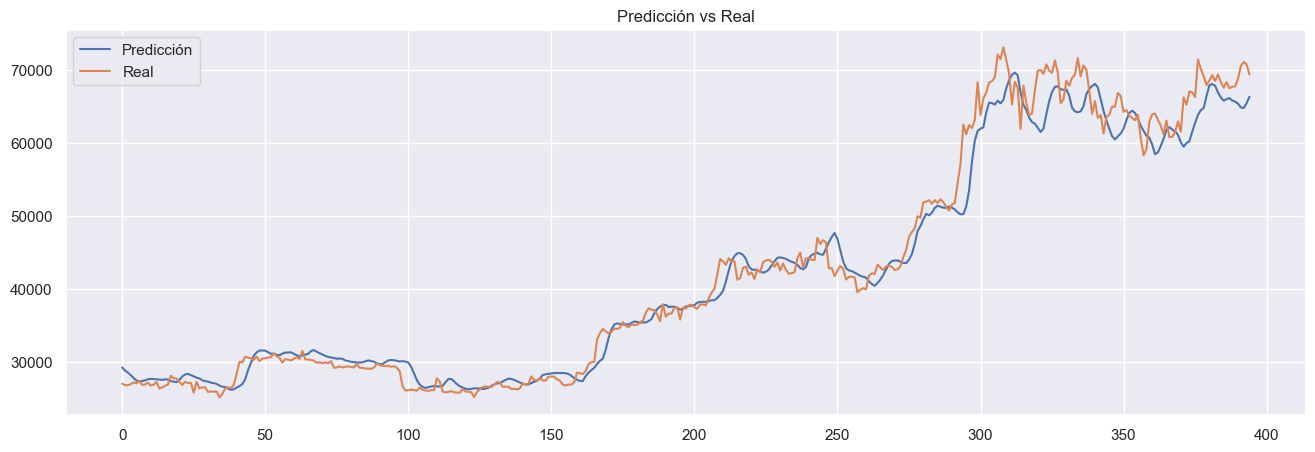

In [112]:
# Realizar predicciones
pred_tr = predecir(modelo, x_tr_s, scaler)
pred_vl = predecir(modelo, x_vl_s, scaler)
pred_ts = predecir(modelo, x_ts_s, scaler)

# pred_tr = np.array(pred_tr)
# pred_vl = np.array(pred_vl)
# # Graficar predicciones
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(pred_ts[:,-1], label='Predicción')
# ax.plot(pred_tr.flatten(), label='Predicción')
# ax.plot(pred_vl.flatten(), label='Predicción')
ax.plot(y_ts[:,-1], label='Real')
ax.set_title('Predicción vs Real')
plt.legend();

ARIMA

In [25]:
import pmdarima as pm

# Assuming your time series data is in a pandas DataFrame 'df' with a datetime index

# Fit the model using auto_arima to find the best p, d, q
model = pm.auto_arima(df_bitcoin['close'], seasonal=False, stepwise=True, suppress_warnings=True)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4219
Model:               SARIMAX(2, 1, 5)   Log Likelihood              -34104.439
Date:                Tue, 11 Jun 2024   AIC                          68226.878
Time:                        20:22:23   BIC                          68284.002
Sample:                             0   HQIC                         68247.072
                               - 4219                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.3554     14.171      1.154      0.248     -11.420      44.131
ar.L1          0.8098      0.008    101.226      0.000       0.794       0.825
ar.L2         -0.9668      0.008   -122.397      0.0

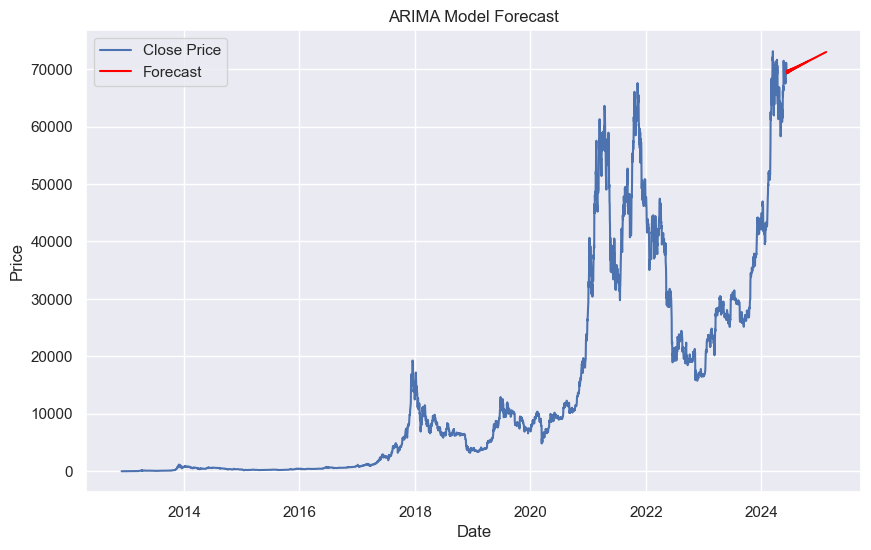

In [29]:
# Forecast future values
forecast = model.predict(n_periods=250)

# Graficar las predicciones junto con los datos reales
plt.figure(figsize=(10, 6))
plt.plot(df_bitcoin['close'], label='Close Price')
plt.plot(pd.date_range(df_bitcoin.index[-1], periods=250, freq='D'), forecast, label='Forecast', color='red')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()